# <b> Sleep Disorder Prediction Using Multiple Machine Learning Algorithms: A Comparative Analysis of XGBoost, KNN, Gradient Boosting, and Logistic Regression on Health and Lifestyle Data </b>

# 1. Checking for Required Files and Importing Libraries 

In [171]:
import os
print("Checking for required files:")
files_to_check = ['sleep_preprocessor.pkl', 'sleep_model.pkl', 'sleep_label_encoder.pkl']
for file in files_to_check:
    if os.path.exists(file):
        print(f"✓ {file} exists")
    else:
        print(f"✗ {file} does not exist - needs to be created")

Checking for required files:
✓ sleep_preprocessor.pkl exists
✗ sleep_model.pkl does not exist - needs to be created
✓ sleep_label_encoder.pkl exists


In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder,LabelEncoder ,RobustScaler,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold,cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import ipywidgets as widgets
from IPython.display import display, clear_output
import joblib
import numpy as np
from sklearn.utils.class_weight import compute_class_weight  # Add this import
from sklearn.metrics import classification_report  # Also add this for evaluation


# 2. Data Loading and Initial Exploration

In [173]:
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
df['Sleep Disorder'].fillna('No Disorder', inplace=True)

In [174]:
print("Before balancing:")
print(df['Sleep Disorder'].value_counts())

Before balancing:
Sleep Disorder
No Disorder    219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64


In [175]:
df.head(5)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,No Disorder
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No Disorder
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No Disorder
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [176]:
df.shape

(374, 13)

In [177]:
df.dtypes

Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object

In [178]:
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


In [179]:
columns = [column for column in df.columns if column!='Person ID']

In [180]:
for column in columns:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'Gender': ['Male' 'Female']
Unique values in 'Age': [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 48 49 50 51 52
 53 54 55 56 57 58 59]
Unique values in 'Occupation': ['Software Engineer' 'Doctor' 'Sales Representative' 'Teacher' 'Nurse'
 'Engineer' 'Accountant' 'Scientist' 'Lawyer' 'Salesperson' 'Manager']
Unique values in 'Sleep Duration': [6.1 6.2 5.9 6.3 7.8 6.  6.5 7.6 7.7 7.9 6.4 7.5 7.2 5.8 6.7 7.3 7.4 7.1
 6.6 6.9 8.  6.8 8.1 8.3 8.5 8.4 8.2]
Unique values in 'Quality of Sleep': [6 4 7 5 8 9]
Unique values in 'Physical Activity Level': [42 60 30 40 75 35 45 50 32 70 80 55 90 47 65 85]
Unique values in 'Stress Level': [6 8 7 4 3 5]
Unique values in 'BMI Category': ['Overweight' 'Normal' 'Obese' 'Normal Weight']
Unique values in 'Blood Pressure': ['126/83' '125/80' '140/90' '120/80' '132/87' '130/86' '117/76' '118/76'
 '128/85' '131/86' '128/84' '115/75' '135/88' '129/84' '130/85' '115/78'
 '119/77' '121/79' '125/82' '135/90' '122/80' '142/92' '140/95

# 3. Data Preprocessing 

In [181]:
# Replace NaN in 'Sleep Disorder' with 'No Disorder'
df['Sleep Disorder'].fillna('No Disorder', inplace=True)


In [182]:
# Value counts of 'Sleep Disorder'
sleep_disorder_counts = df['Sleep Disorder'].value_counts()

print("Value counts of 'Sleep Disorder':")
print(sleep_disorder_counts)

Value counts of 'Sleep Disorder':
Sleep Disorder
No Disorder    219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64


In [183]:
#Standardize BMI categories
df['BMI Category']=df['BMI Category'].replace({'Normal':'Normal Weight'})
df['BMI Category'].value_counts()

BMI Category
Normal Weight    216
Overweight       148
Obese             10
Name: count, dtype: int64

# 4. Data Visualization

> ## BMI Category Distributiion

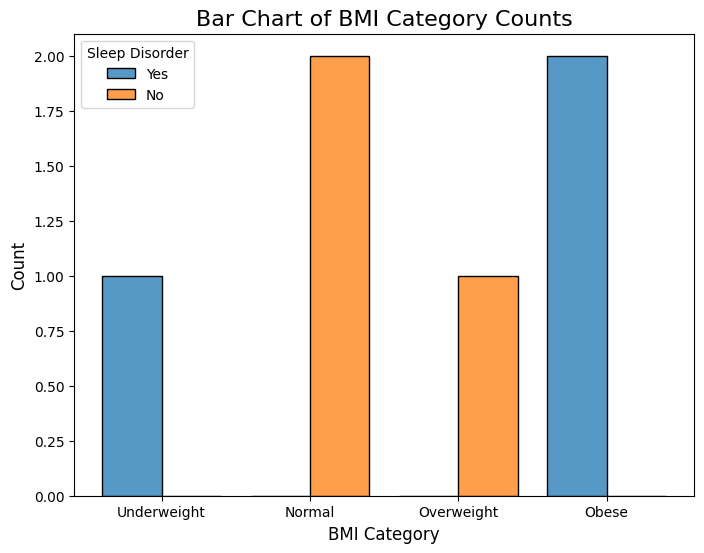

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame
data = {
    'BMI Category': ['Underweight', 'Normal', 'Overweight', 'Obese', 'Normal', 'Obese'],
    'Sleep Disorder': ['Yes', 'No', 'No', 'Yes', 'No', 'Yes']
}
df = pd.DataFrame(data)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df,
    x='BMI Category',
    hue='Sleep Disorder',
    multiple='dodge',  # Separate bars by color
    shrink=0.8,        # Adjust bar width
    discrete=True      # Treat 'BMI Category' as discrete
)

# Add title and labels
plt.title('Bar Chart of BMI Category Counts', fontsize=16)
plt.xlabel('BMI Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show plot
plt.show()


> ## Sleep Quality Distributiion

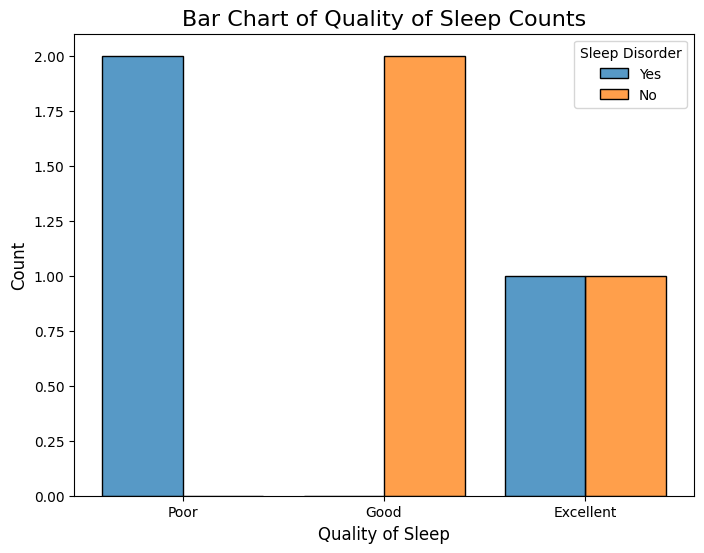

In [185]:
data = {
    'Quality of Sleep': ['Poor', 'Good', 'Good', 'Poor', 'Excellent', 'Excellent'],
    'Sleep Disorder': ['Yes', 'No', 'No', 'Yes', 'No', 'Yes']
}
df = pd.DataFrame(data)


plt.figure(figsize=(8, 6))
sns.histplot(
    data=df,
    x='Quality of Sleep',
    hue='Sleep Disorder',
    multiple='dodge',  # Separate bars by color
    shrink=0.8,        # Adjust bar width
    discrete=True      # Treat 'Quality of Sleep' as discrete
)

# Add title and labels
plt.title('Bar Chart of Quality of Sleep Counts', fontsize=16)
plt.xlabel('Quality of Sleep', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


> ## Occupation Distributiion

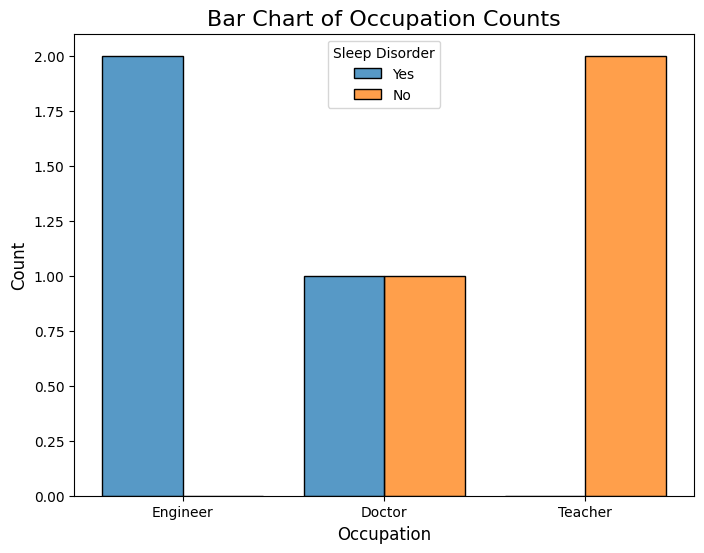

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample DataFrame
data = {
    'Occupation': ['Engineer', 'Doctor', 'Teacher', 'Engineer', 'Teacher', 'Doctor'],
    'Sleep Disorder': ['Yes', 'No', 'No', 'Yes', 'No', 'Yes']
}
df = pd.DataFrame(data)

# Create a histogram
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df,
    x='Occupation',
    hue='Sleep Disorder',
    multiple='dodge',  # Separate bars by color
    shrink=0.8,        # Adjust bar width
    discrete=True      # Treat 'Occupation' as discrete
)

# Add title and labels
plt.title('Bar Chart of Occupation Counts', fontsize=16)
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show plot
plt.show()


> ## Gender and Sleep Quality Analysis

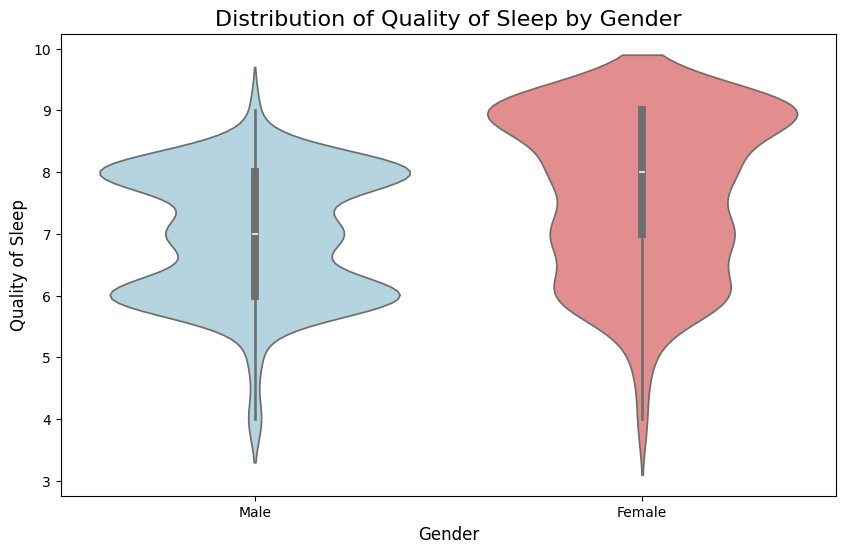

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv') 
# Create the visualization
color_palette = {'Male': 'lightblue', 'Female': 'lightcoral'}
plt.figure(figsize=(10, 6))
sns.violinplot(x='Gender', y='Quality of Sleep', data=df, palette=color_palette)
plt.title('Distribution of Quality of Sleep by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Quality of Sleep', fontsize=12)
plt.show()

> ## Stress Level and Sleep Quality 

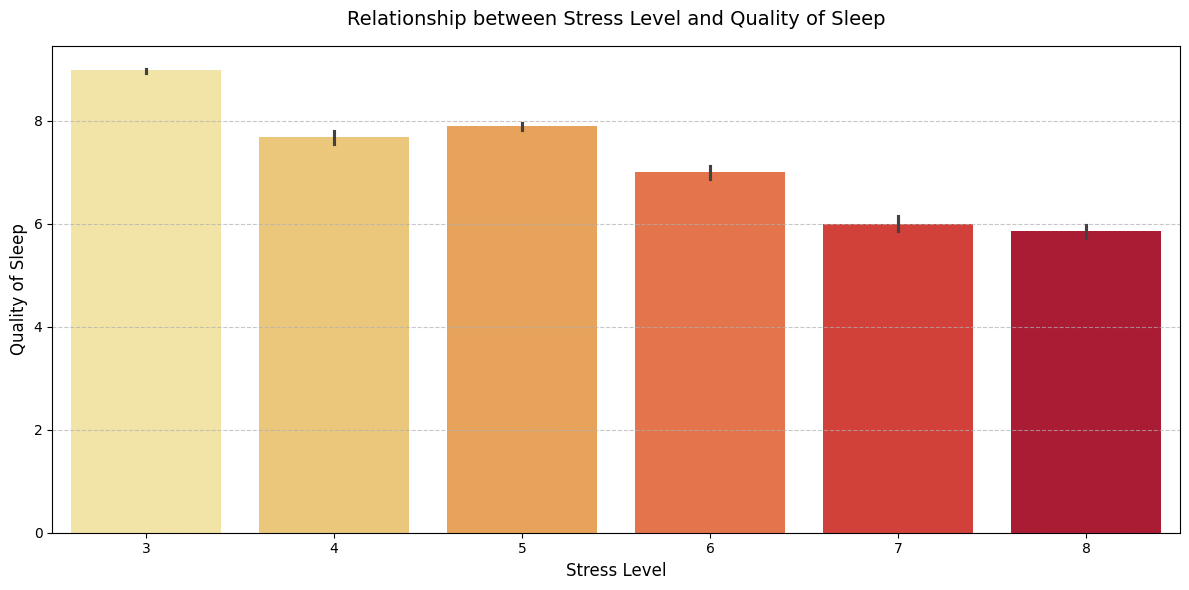

In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create the figure and axes
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(x='Stress Level', y='Quality of Sleep', data=df, 
            palette='YlOrRd',  # Using a color palette that goes from yellow to red
            ci=95)  # Adding confidence intervals

# Customize the plot
plt.title('Relationship between Stress Level and Quality of Sleep', fontsize=14, pad=15)
plt.xlabel('Stress Level', fontsize=12)
plt.ylabel('Quality of Sleep', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# 5. Feature Engineering

**Splitting Blood Pressure into two columns: Systolic and Diastolic**

In [189]:
df = pd.concat([df, df['Blood Pressure'].str.split('/', expand=True)], axis=1).drop('Blood Pressure', axis=1)
df = df.rename(columns={0: 'Systolic', 1: 'Diastolic'})

In [190]:
df['Systolic'] = df['Systolic'].astype(float)
df['Diastolic'] = df['Diastolic'].astype(float)

# 6. Correlation Analysis

In [191]:
numeric_features = ['Age', 'Sleep Duration', 
                    'Physical Activity Level', 
                    'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

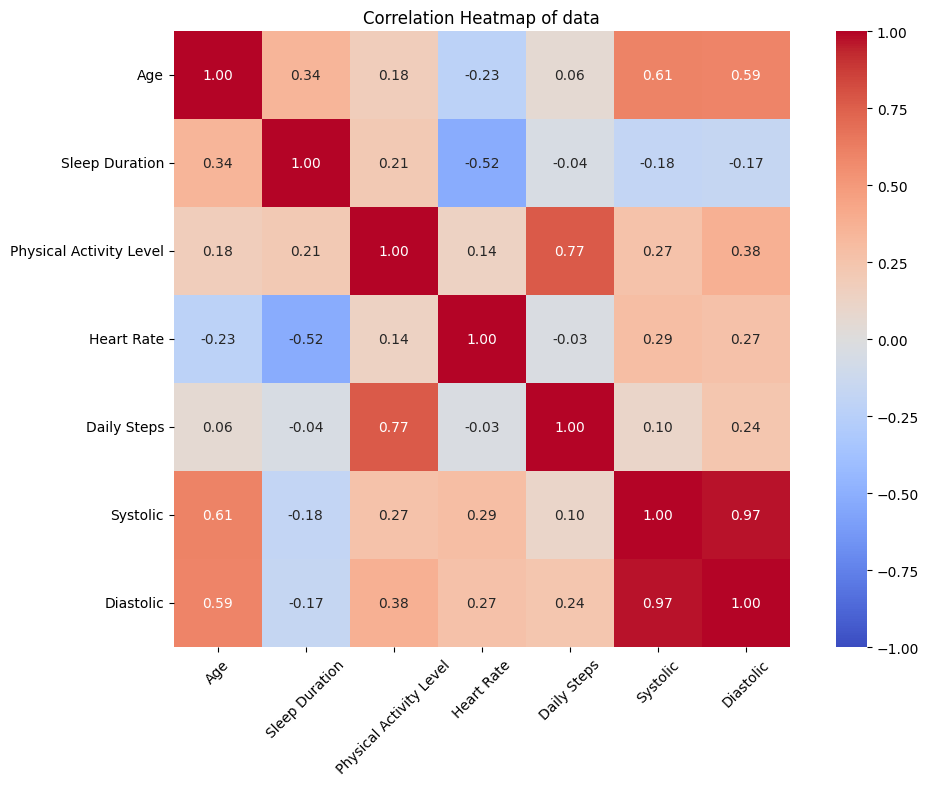

In [192]:
# Calculate the correlation matrix
corr_matrix = df[numeric_features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap without the mask
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, square=True)

# Customize plot labels and title
plt.title('Correlation Heatmap of data')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show plot
plt.show()


# 7. Model Preparation

>Drop unnecessary columns and encode target variable

In [193]:
df.drop(columns=['Person ID'],inplace = True)

In [194]:
label_encoder = LabelEncoder()
df['Sleep Disorder'] = label_encoder.fit_transform(df['Sleep Disorder'])

In [195]:
print(label_encoder.classes_)

['Insomnia' 'Sleep Apnea' nan]


> Feature Preprocessing

In [196]:
numeric_features = ['Age', 'Sleep Duration',  
                    'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

categorical_features = ['Occupation','Quality of Sleep','Gender', 
                    'Physical Activity Level', 'Stress Level', 'BMI Category']


In [197]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first',sparse_output =False, handle_unknown='ignore'), categorical_features)
    ])

In [198]:
X = df.drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder']

In [199]:
X_preprocessed = preprocessor.fit_transform(X)

In [200]:
  # Calculate class weights
class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df['Sleep Disorder']),
        y=df['Sleep Disorder']
    )
class_weight_dict = dict(zip(np.unique(df['Sleep Disorder']), class_weights))

> Handling Data Imbalance

In [201]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Perform SMOTE oversampling
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_smote, y_smote = smote.fit_resample(X_preprocessed, y)

In [202]:
# Splitting the data into training and testing sets (e.g., 75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42)

# 8. Model Training and Evaluation

Training K-Nearest Neighbors...
Training Gradient Boosting...
Training Logistic Regression...
Training XGBoost...
[0]	validation_0-mlogloss:1.04879
[1]	validation_0-mlogloss:1.00178
[2]	validation_0-mlogloss:0.95862
[3]	validation_0-mlogloss:0.92061
[4]	validation_0-mlogloss:0.88492
[5]	validation_0-mlogloss:0.85127
[6]	validation_0-mlogloss:0.81846
[7]	validation_0-mlogloss:0.78775
[8]	validation_0-mlogloss:0.76148
[9]	validation_0-mlogloss:0.73591
[10]	validation_0-mlogloss:0.71327
[11]	validation_0-mlogloss:0.69089
[12]	validation_0-mlogloss:0.66928
[13]	validation_0-mlogloss:0.65070
[14]	validation_0-mlogloss:0.63233
[15]	validation_0-mlogloss:0.61360
[16]	validation_0-mlogloss:0.59611
[17]	validation_0-mlogloss:0.58251
[18]	validation_0-mlogloss:0.56813
[19]	validation_0-mlogloss:0.55467
[20]	validation_0-mlogloss:0.54171
[21]	validation_0-mlogloss:0.52965
[22]	validation_0-mlogloss:0.51912
[23]	validation_0-mlogloss:0.50770
[24]	validation_0-mlogloss:0.49723
[25]	validation_0-mlo

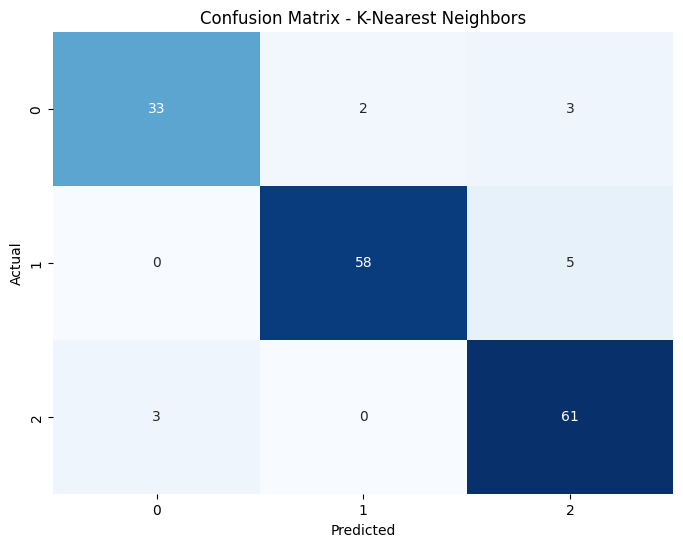


Evaluating Gradient Boosting...

Results for Gradient Boosting:
Accuracy: 0.915
Precision: 0.916
Recall: 0.915
F1-score: 0.914

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        38
           1       0.94      0.92      0.93        63
           2       0.90      0.97      0.93        64

    accuracy                           0.92       165
   macro avg       0.92      0.90      0.91       165
weighted avg       0.92      0.92      0.91       165



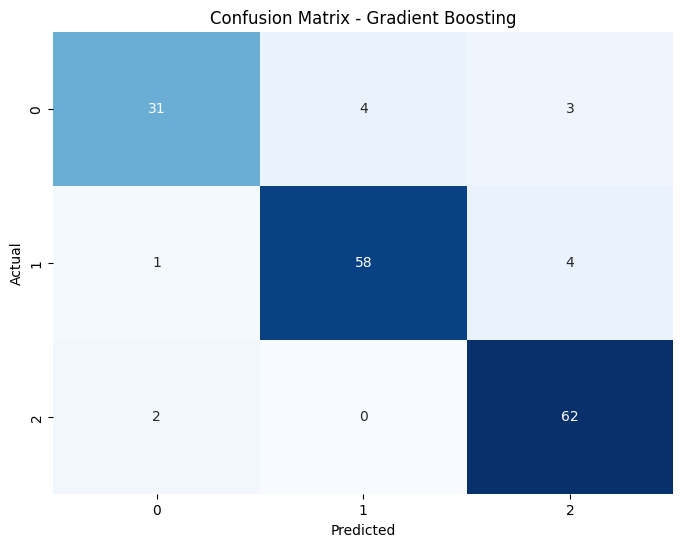


Evaluating Logistic Regression...

Results for Logistic Regression:
Accuracy: 0.903
Precision: 0.905
Recall: 0.903
F1-score: 0.902

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86        38
           1       0.91      0.92      0.91        63
           2       0.88      0.95      0.92        64

    accuracy                           0.90       165
   macro avg       0.91      0.89      0.90       165
weighted avg       0.90      0.90      0.90       165



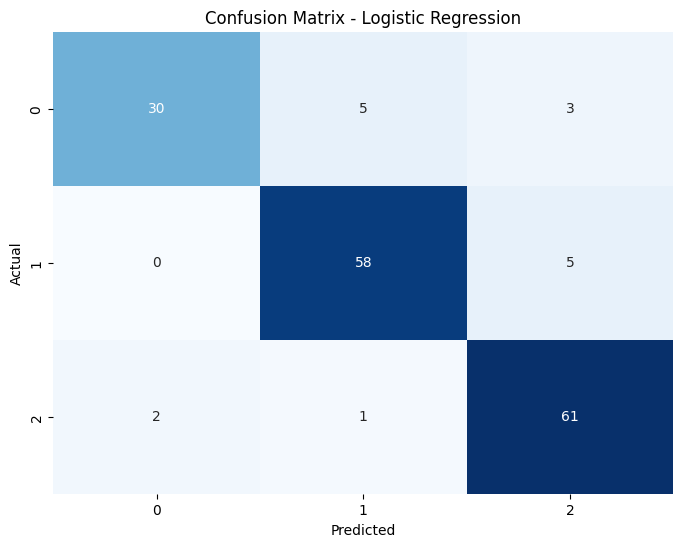


Evaluating XGBoost...

Results for XGBoost:
Accuracy: 0.921
Precision: 0.923
Recall: 0.921
F1-score: 0.922

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        38
           1       0.97      0.94      0.95        63
           2       0.92      0.92      0.92        64

    accuracy                           0.92       165
   macro avg       0.91      0.92      0.92       165
weighted avg       0.92      0.92      0.92       165



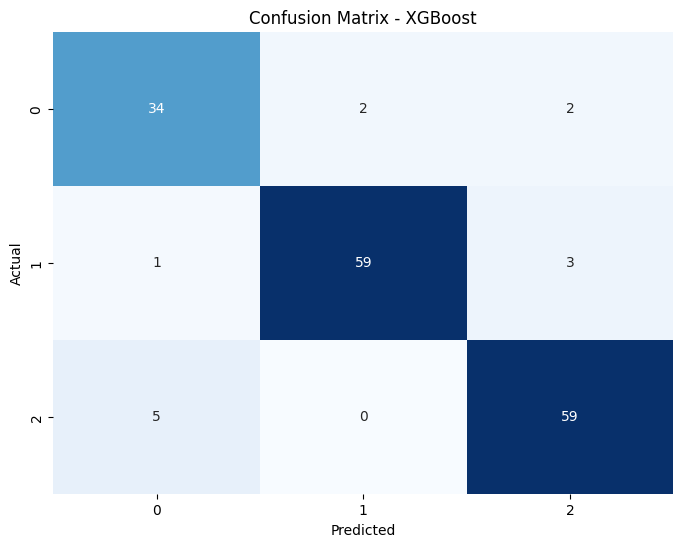


Performing cross-validation for all models:

K-Nearest Neighbors Cross-validation Results:
Scores: [0.9242424242424242, 0.8939393939393939, 0.9083969465648855, 0.9007633587786259, 0.8854961832061069]
Mean CV score: 0.903 (+/- 0.026)

Gradient Boosting Cross-validation Results:
Scores: [0.9242424242424242, 0.9090909090909091, 0.916030534351145, 0.9236641221374046, 0.9083969465648855]
Mean CV score: 0.916 (+/- 0.014)

Logistic Regression Cross-validation Results:
Scores: [0.9166666666666666, 0.9015151515151515, 0.8931297709923665, 0.916030534351145, 0.8931297709923665]
Mean CV score: 0.904 (+/- 0.021)

Performing cross-validation for XGBoost:

XGBoost Cross-validation Results:
Scores: [0.9242424242424242, 0.9015151515151515, 0.9236641221374046, 0.9236641221374046, 0.9236641221374046]
Mean CV score: 0.919 (+/- 0.018)


In [203]:
# Essential imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Initialize classifiers
kneighbors_classifier = KNeighborsClassifier(n_neighbors=5)
logistic_regression = LogisticRegression()
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Initialize XGBoost separately
xgboost_model = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    max_depth=4,
    min_child_weight=3,
    gamma=0.2,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=2
)

# Dictionary of models
models = {
    'K-Nearest Neighbors': kneighbors_classifier,
    'Gradient Boosting': gradient_boosting,
    'Logistic Regression': logistic_regression,
}

# Fit models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

# Train with sample weights
    sample_weights = np.ones(len(y_train))
    for idx, label in enumerate(y_train):
        sample_weights[idx] = class_weight_dict[label]

# Separate XGBoost training
print("Training XGBoost...")
xgboost_model.fit(
    X_train, 
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=True
)


joblib.dump(preprocessor, 'sleep_preprocessor.pkl')
joblib.dump(label_encoder, 'sleep_label_encoder.pkl')

# In your training code:
joblib.dump(kneighbors_classifier, 'knn_model.pkl')
joblib.dump(gradient_boosting, 'gb_model.pkl')
joblib.dump(logistic_regression, 'lr_model.pkl')
joblib.dump(xgboost_model, 'xgb_model.pkl')


# Model evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print metrics
    print(f'\nResults for {model_name}:')
    print(f'Accuracy: {accuracy:.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1-score: {f1:.3f}')
    
    # Print classification report
    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix plot
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    return y_pred

# Evaluate regular models
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    evaluate_model(model, X_test, y_test, name)

# Evaluate XGBoost separately
print("\nEvaluating XGBoost...")
evaluate_model(xgboost_model, X_test, y_test, 'XGBoost')

# Cross-validation for all models
print("\nPerforming cross-validation for all models:")
for name, model in models.items():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X_smote, y_smote):
        X_train_cv, X_val_cv = X_smote[train_idx], X_smote[val_idx]
        y_train_cv, y_val_cv = y_smote[train_idx], y_smote[val_idx]
        
        model.fit(X_train_cv, y_train_cv)
        score = accuracy_score(y_val_cv, model.predict(X_val_cv))
        scores.append(score)
    
    print(f"\n{name} Cross-validation Results:")
    print(f"Scores: {scores}")
    print(f"Mean CV score: {np.mean(scores):.3f} (+/- {np.std(scores) * 2:.3f})")

# XGBoost cross-validation
print("\nPerforming cross-validation for XGBoost:")
xgboost_scores = []
for train_idx, val_idx in cv.split(X_smote, y_smote):
    X_train_cv, X_val_cv = X_smote[train_idx], X_smote[val_idx]
    y_train_cv, y_val_cv = y_smote[train_idx], y_smote[val_idx]
    
    xgboost_cv = xgb.XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        objective='multi:softprob'
    )
    
    xgboost_cv.fit(X_train_cv, y_train_cv)
    score = accuracy_score(y_val_cv, xgboost_cv.predict(X_val_cv))
    xgboost_scores.append(score)

print("\nXGBoost Cross-validation Results:")
print(f"Scores: {xgboost_scores}")
print(f"Mean CV score: {np.mean(xgboost_scores):.3f} (+/- {np.std(xgboost_scores) * 2:.3f})")

# 9. Model Comparison Visualization

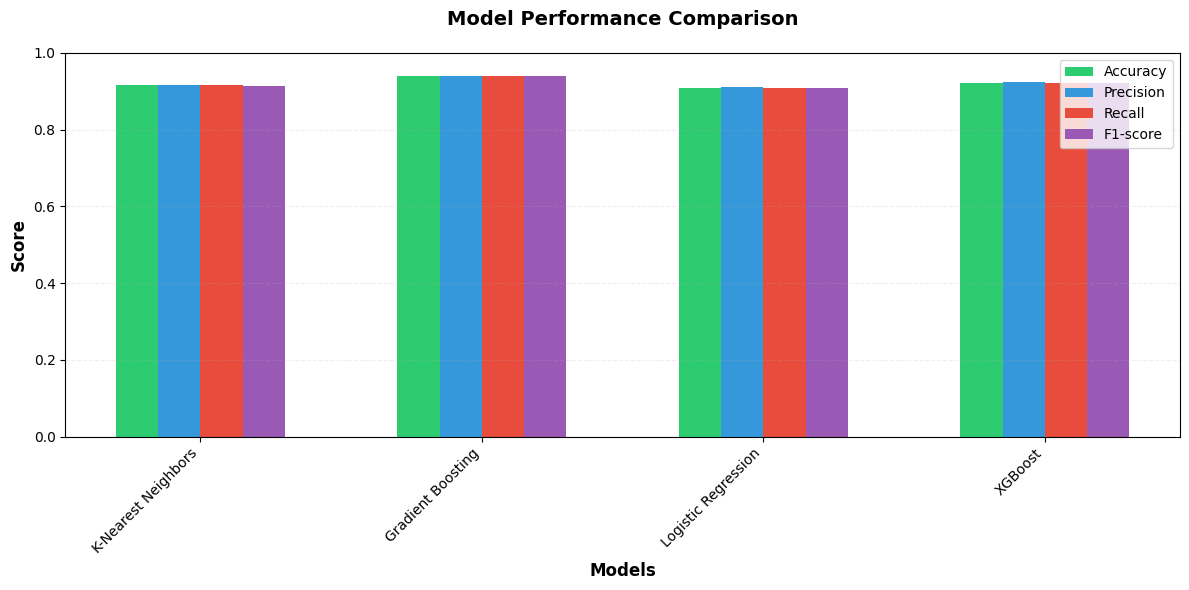


Detailed Model Performance Metrics:
--------------------------------------------------------------------------------
Model                         Accuracy    Precision       Recall     F1-Score
--------------------------------------------------------------------------------
K-Nearest Neighbors              0.915        0.916        0.915        0.914
Gradient Boosting                0.939        0.940        0.939        0.939
Logistic Regression              0.909        0.910        0.909        0.908
XGBoost                          0.921        0.923        0.921        0.922
--------------------------------------------------------------------------------


In [204]:
def create_model_comparison_plot(all_models_results):
    """
    Create a comparison plot of model performances using multiple metrics
    """
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Set width of bars and positions of the bars
    bar_width = 0.15
    r1 = np.arange(len(all_models_results))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    
    # Create bars
    plt.bar(r1, [x['Accuracy'] for x in all_models_results.values()], 
            width=bar_width, label='Accuracy', color='#2ecc71')
    plt.bar(r2, [x['Precision'] for x in all_models_results.values()], 
            width=bar_width, label='Precision', color='#3498db')
    plt.bar(r3, [x['Recall'] for x in all_models_results.values()], 
            width=bar_width, label='Recall', color='#e74c3c')
    plt.bar(r4, [x['F1'] for x in all_models_results.values()], 
            width=bar_width, label='F1-score', color='#9b59b6')
    
    # Add labels
    plt.xlabel('Models', fontsize=12, fontweight='bold')
    plt.ylabel('Score', fontsize=12, fontweight='bold')
    plt.title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
    
    # Add xticks on the middle of the group bars
    plt.xticks([r + bar_width*1.5 for r in range(len(all_models_results))], 
               list(all_models_results.keys()), 
               rotation=45, 
               ha='right')
    
    # Create legend
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
    # Add grid and adjust layout
    plt.grid(True, axis='y', linestyle='--', alpha=0.2)
    plt.tight_layout()
    
    # Set y-axis limits from 0 to 1
    plt.ylim(0, 1.0)
    
    return fig

# Dictionary to store all model results
all_models_results = {}

# Evaluate and store results for regular models
for name, model in models.items():
    y_pred = model.predict(X_test)
    
    all_models_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }

# Add XGBoost results
y_pred_xgb = xgboost_model.predict(X_test)
all_models_results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb, average='weighted'),
    'Recall': recall_score(y_test, y_pred_xgb, average='weighted'),
    'F1': f1_score(y_test, y_pred_xgb, average='weighted')
}

# Create and show the comparison plot
fig = create_model_comparison_plot(all_models_results)
plt.show()

# Print numeric results in a formatted table
print("\nDetailed Model Performance Metrics:")
print("-" * 80)
print(f"{'Model':<25} {'Accuracy':>12} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
print("-" * 80)
for model_name, metrics in all_models_results.items():
    print(f"{model_name:<25} {metrics['Accuracy']:>12.3f} {metrics['Precision']:>12.3f} "
          f"{metrics['Recall']:>12.3f} {metrics['F1']:>12.3f}")
print("-" * 80)

# 10. Prediction System

In [205]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load and prepare data
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')
df['Sleep Disorder'].fillna('No Disorder', inplace=True)

print("Before balancing:")
print(df['Sleep Disorder'].value_counts())

# Split blood pressure
df = pd.concat([df, df['Blood Pressure'].str.split('/', expand=True)], axis=1).drop('Blood Pressure', axis=1)
df = df.rename(columns={0: 'Systolic', 1: 'Diastolic'})
df['Systolic'] = df['Systolic'].astype(float)
df['Diastolic'] = df['Diastolic'].astype(float)

# Drop unnecessary columns
df.drop(columns=['Person ID'], inplace=True)

# Encode target variable
label_encoder = LabelEncoder()
df['Sleep Disorder'] = label_encoder.fit_transform(df['Sleep Disorder'])

# Define features
numeric_features = ['Age', 'Sleep Duration', 'Heart Rate', 'Daily Steps', 
                   'Systolic', 'Diastolic']
categorical_features = ['Occupation', 'Quality of Sleep', 'Gender', 
                      'Physical Activity Level', 'Stress Level', 'BMI Category']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), 
         categorical_features)
    ])

# Split features and target
X = df.drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder']

# Preprocess features
X_preprocessed = preprocessor.fit_transform(X)

# Modified SMOTE strategy
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_smote, y_smote = smote.fit_resample(X_preprocessed, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.25, random_state=42
)

# Initialize all models
xgb_model = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    max_depth=4,
    min_child_weight=3,
    gamma=0.2,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=5
)

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski'
)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

lr_model = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    random_state=42
)

# Train all models
print("\nTraining models...")

print("Training XGBoost...")
xgb_model.fit(X_train, y_train)

print("Training KNN...")
knn_model.fit(X_train, y_train)

print("Training Gradient Boosting...")
gb_model.fit(X_train, y_train)

print("Training Logistic Regression...")
lr_model.fit(X_train, y_train)

# Save all models and preprocessors
print("\nSaving models...")
joblib.dump(preprocessor, 'sleep_preprocessor.pkl')
joblib.dump(label_encoder, 'sleep_label_encoder.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(knn_model, 'knn_model.pkl')
joblib.dump(gb_model, 'gb_model.pkl')
joblib.dump(lr_model, 'lr_model.pkl')

# Create test cases
test_cases = pd.DataFrame([
    # Test case 1: most likely high risk for sleep apnea
    {
        'Age': 35,
        'Sleep Duration': 4.5,
        'Quality of Sleep': 2,
        'Physical Activity Level': 30,
        'Stress Level': 9,
        'BMI Category': 'Normal',
        'Heart Rate': 85,
        'Daily Steps': 4000,
        'Occupation': 'Software Engineer',
        'Gender': 'Male',
        'Systolic': 120,
        'Diastolic': 80
    },
    # Test case 2: most likely high risk for insomnia
    {
        'Age': 55,
        'Sleep Duration': 6.5,
        'Quality of Sleep': 4,
        'Physical Activity Level': 20,
        'Stress Level': 6,
        'BMI Category': 'Obese',
        'Heart Rate': 82,
        'Daily Steps': 3000,
        'Occupation': 'Sales Representative',
        'Gender': 'Male',
        'Systolic': 130,
        'Diastolic': 85
    },
    # Test case 3: most likely no disorder test case
    {
        'Age': 28,
        'Sleep Duration': 7.5,
        'Quality of Sleep': 8,
        'Physical Activity Level': 60,
        'Stress Level': 3,
        'BMI Category': 'Normal',
        'Heart Rate': 70,
        'Daily Steps': 10000,
        'Occupation': 'Teacher',
        'Gender': 'Female',
        'Systolic': 115,
        'Diastolic': 75
    }
])


# Test and print results for all models
models = {
    'XGBoost': xgb_model,
    'KNN': knn_model,
    'Gradient Boosting': gb_model,
    'Logistic Regression': lr_model
}

# Process test data
test_processed = preprocessor.transform(test_cases)

print("\nModel Predictions for Test Cases:")
for model_name, model in models.items():
    print(f"\n{model_name} Results:")
    predictions = model.predict(test_processed)
    probabilities = model.predict_proba(test_processed)
    
    for i, (pred, probs) in enumerate(zip(predictions, probabilities)):
        print(f"\nTest Case {i+1}:")
        print(f"Predicted: {label_encoder.inverse_transform([pred])[0]}")
        print("Probabilities:")
        for label, prob in zip(label_encoder.classes_, probs):
            print(f"{label}: {prob:.2%}")
    
    # Print model evaluation metrics
    y_pred = model.predict(X_test)
    print(f"\n{model_name} Model Evaluation:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Before balancing:
Sleep Disorder
No Disorder    219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

Training models...
Training XGBoost...
Training KNN...
Training Gradient Boosting...
Training Logistic Regression...

Saving models...

Model Predictions for Test Cases:

XGBoost Results:

Test Case 1:
Predicted: Sleep Apnea
Probabilities:
Insomnia: 21.04%
No Disorder: 16.78%
Sleep Apnea: 62.18%

Test Case 2:
Predicted: Insomnia
Probabilities:
Insomnia: 71.04%
No Disorder: 3.17%
Sleep Apnea: 25.79%

Test Case 3:
Predicted: No Disorder
Probabilities:
Insomnia: 0.73%
No Disorder: 94.44%
Sleep Apnea: 4.82%

XGBoost Model Evaluation:
              precision    recall  f1-score   support

    Insomnia       0.91      0.84      0.88        38
 No Disorder       0.89      0.97      0.93        64
 Sleep Apnea       0.95      0.90      0.93        63

    accuracy                           0.92       165
   macro avg       0.92      0.91      0.91       165
weighted avg       0.

# Sleep Disorder Prediction System with User Input

In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import joblib
import pandas as pd

def create_prediction_interface():
    # Load models...
    try:
        knn_model = joblib.load('knn_model.pkl')
        gb_model = joblib.load('gb_model.pkl')
        lr_model = joblib.load('lr_model.pkl')
        xgb_model = joblib.load('xgb_model.pkl')
        preprocessor = joblib.load('sleep_preprocessor.pkl')
        label_encoder = joblib.load('sleep_label_encoder.pkl')
        
        # a dictionary of models
        models = {
            'K-Nearest Neighbors': knn_model,
            'Gradient Boosting': gb_model,
            'Logistic Regression': lr_model,
            'XGBoost': xgb_model
        }
        
    except Exception as e:
        print(f"Error loading models: {str(e)}")
        return
    
     #  widgets with ranges matching the test cases
    age = widgets.IntSlider(
        value=35,  # Default from test case 1
        min=18,
        max=100,
        description='Age:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    gender = widgets.Dropdown(
        options=['Male', 'Female'],
        value='Male',  # Matches test cases
        description='Gender:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    sleep_duration = widgets.FloatSlider(
        value=4.5,  # Default from test case 1
        min=0,
        max=24,
        step=0.1,
        description='Sleep Duration:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    quality_sleep = widgets.IntSlider(
        value=2,  # Default from test case 1
        min=1,
        max=10,
        description='Sleep Quality:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    physical_activity = widgets.IntSlider(
        value=30,  # Default from test case 1
        min=0,
        max=600,
        description='Physical Act...',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    stress_level = widgets.IntSlider(
        value=9,  # Default from test case 1
        min=1,
        max=10,
        description='Stress Level:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    occupation = widgets.Dropdown(
        options=['Software Engineer', 'Doctor', 'Nurse', 'Sales Representative', 'Teacher'],
        value='Software Engineer',  # Matches test case 1
        description='Occupation:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    bmi_category = widgets.Dropdown(
        options=['Normal', 'Overweight', 'Obese'],
        value='Normal',  # Matches test case 1
        description='BMI Category:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    heart_rate = widgets.IntSlider(
        value=85,  # Default from test case 1
        min=40,
        max=200,
        description='Heart Rate:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    daily_steps = widgets.IntSlider(
        value=4000,  # Default from test case 1
        min=0,
        max=30000,
        description='Daily Steps:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    systolic = widgets.IntSlider(
        value=120,  # Default from test case 1
        min=90,
        max=200,
        description='Systolic BP:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    diastolic = widgets.IntSlider(
        value=80,  # Default from test case 1
        min=60,
        max=130,
        description='Diastolic BP:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    predict_button = widgets.Button(
        description='Predict',
        layout=widgets.Layout(width='100px')
    )
    
    # Add preset buttons for test cases
    test_case_1_button = widgets.Button(
        description='Load Test Case 1',
        layout=widgets.Layout(width='150px')
    )
    
    test_case_2_button = widgets.Button(
        description='Load Test Case 2',
        layout=widgets.Layout(width='150px')
    )
    test_case_3_button = widgets.Button(
        description='Load Test Case 3',
        layout=widgets.Layout(width='150px')
    )
    
    def load_test_case_1(b):
        age.value = 35
        sleep_duration.value = 4.5
        quality_sleep.value = 2
        physical_activity.value = 30
        stress_level.value = 9
        bmi_category.value = 'Normal'
        heart_rate.value = 85
        daily_steps.value = 4000
        occupation.value = 'Software Engineer'
        gender.value = 'Male'
        systolic.value = 120
        diastolic.value = 80
    
    def load_test_case_2(b):
        age.value = 55
        sleep_duration.value = 6.5
        quality_sleep.value = 4
        physical_activity.value = 20
        stress_level.value = 6
        bmi_category.value = 'Obese'
        heart_rate.value = 82
        daily_steps.value = 3000
        occupation.value = 'Sales Representative'
        gender.value = 'Male'
        systolic.value = 130
        diastolic.value = 85
    
    def load_test_case_3(b):
        age.value = 28
        sleep_duration.value = 7.5
        quality_sleep.value = 8
        physical_activity.value = 60
        stress_level.value = 3
        bmi_category.value = 'Normal'
        heart_rate.value = 70
        daily_steps.value = 10000
        occupation.value = 'Teacher'
        gender.value = 'Female'
        systolic.value = 115
        diastolic.value = 75
    
    # HTML widget for results instead of Output widget
    result_display = widgets.HTML(value="")

    # model selector dropdown
    model_selector = widgets.Dropdown(
        options=list(models.keys()),
        value='XGBoost',  # Default model
        description='Select Model:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    def make_prediction(b):
        try:
            # input data matching the test case structure
            input_data = pd.DataFrame({
                'Age': [age.value],
                'Sleep Duration': [sleep_duration.value],
                'Quality of Sleep': [quality_sleep.value],
                'Physical Activity Level': [physical_activity.value],
                'Stress Level': [stress_level.value],
                'BMI Category': [bmi_category.value],
                'Heart Rate': [heart_rate.value],
                'Daily Steps': [daily_steps.value],
                'Occupation': [occupation.value],
                'Gender': [gender.value],
                'Systolic': [systolic.value],
                'Diastolic': [diastolic.value]
            })
            
            # Process and predict
            input_processed = preprocessor.transform(input_data)
            selected_model = models[model_selector.value]
            prediction = selected_model.predict(input_processed)
            probabilities = selected_model.predict_proba(input_processed)
            
            # Get results
            pred_label = label_encoder.inverse_transform(prediction)[0]
            
            # Format the HTML output
            html_output = f"""
            <div style='padding: 10px; background-color: #f8f9fa; border-radius: 5px;'>
                <h4>Predicted Sleep Disorder: {pred_label}</h4>
                <h4>Probabilities:</h4>
                <ul>
            """
            
            # Add probabilities
            for label, prob in zip(label_encoder.classes_, probabilities[0]):
                html_output += f"<li>{label}: {prob:.2%}</li>"
            
            html_output += "</ul><h4>Recommendations:</h4><ul>"
            
            # Add recommendations based on prediction
            if pred_label == "No Disorder":
                recommendations = [
                    "✓ Maintain your current sleep habits",
                    "✓ Continue regular physical activity",
                    "✓ Monitor sleep quality regularly"
                ]
            elif pred_label == "Insomnia":
                recommendations = [
                    "! Consider consulting a sleep specialist",
                    "! Establish a regular sleep schedule",
                    "! Reduce screen time before bed",
                    "! Practice relaxation techniques"
                ]
            else:  # Sleep Apnea
                recommendations = [
                    "! Consult a healthcare provider for proper diagnosis",
                    "! Consider a sleep study",
                    "! Maintain a healthy weight",
                    "! Sleep on your side instead of back"
                ]
            
            for rec in recommendations:
                html_output += f"<li>{rec}</li>"
            
            html_output += "</ul></div>"
            
            # Update the display
            result_display.value = html_output
            
        except Exception as e:
            result_display.value = f"<div style='color: red;'>Error making prediction: {str(e)}</div>"
    
    # Your existing widget creation code...
    # Connect button handlers
    predict_button.on_click(make_prediction)
    test_case_1_button.on_click(load_test_case_1)
    test_case_2_button.on_click(load_test_case_2)
    test_case_3_button.on_click(load_test_case_3)
    
    
    # Modify your layout to use the HTML widget instead of Output
    layout = widgets.VBox([
        widgets.HTML(value="<h2>Sleep Disorder Prediction System</h2>"),
        model_selector, 
        widgets.HBox([test_case_1_button, test_case_2_button, test_case_3_button]),
        widgets.HBox([widgets.VBox([age]), widgets.VBox([gender])]),
        widgets.HBox([widgets.VBox([sleep_duration]), widgets.VBox([quality_sleep])]),
        widgets.HBox([widgets.VBox([physical_activity]), widgets.VBox([stress_level])]),
        widgets.HBox([widgets.VBox([occupation]), widgets.VBox([bmi_category])]),
        widgets.HBox([widgets.VBox([heart_rate]), widgets.VBox([daily_steps])]),
        widgets.HBox([widgets.VBox([systolic]), widgets.VBox([diastolic])]),
        predict_button,
        result_display  # Use the HTML widget instead
    ], layout=widgets.Layout(padding='10px'))

# Display medical disclaimer

    disclaimer = """
        <div style="background-color: #f8f9fa; padding: 20px; margin-bottom: 20px; border: 1px solid #ddd; border-radius: 5px;">
            <p style="color: #721c24; margin: 0; margin-bottom: 15px;">
                <strong>Important Medical and Model Limitations Disclaimer:</strong>
            </p>
            
            <p style="color: #721c24; margin: 0; margin-bottom: 15px;">
                This prediction tool has important limitations that users must be aware of. The model is trained exclusively on a limited dataset of 374 individuals, consisting primarily of medical professionals with an unbalanced representation of sleep disorders (219 No Disorder, 78 Sleep Apnea, 77 Insomnia cases). This narrow demographic distribution may not accurately represent the general population's sleep patterns and disorders.
            </p>
            
            <p style="color: #721c24; margin: 0; margin-bottom: 15px;">
                The model's predictions are based on simplified data patterns and may not capture the full complexity of sleep disorders. Different machine learning models may provide conflicting predictions, indicating inherent uncertainty in the analysis. The tool lacks comprehensive medical context and historical patient data that would be available in a clinical setting. Therefore, its accuracy metrics should not be considered representative of real-world medical diagnosis accuracy.
            </p>
            
            <p style="color: #721c24; margin: 0; margin-bottom: 15px;">
                This tool is strictly for educational and research purposes only. It should never be used as a substitute for professional medical diagnosis, sleep studies, clinical evaluations, or consultation with qualified healthcare providers. Sleep disorders are complex medical conditions that require comprehensive medical examination, detailed patient history, professional sleep studies, and ongoing medical supervision.
            </p>
            
            <p style="color: #721c24; margin: 0;">
                If you have any concerns about your sleep health, please consult with a qualified healthcare provider and seek evaluation at an accredited sleep center. Do not make medical decisions based on this tool's predictions. The tool's results should only be used for educational understanding and as potential discussion points with healthcare providers.
            </p>
        </div>
        """
    
    display(HTML(disclaimer))
    display(layout)

    _interface_created = True
# Run the interface
create_prediction_interface()

## RUN THIS CELL FOR THE SYSTEM'S UI TO LOAD :)

c:\Users\bbles\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\bbles\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\bbles\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\bbles\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1, 3, 4] during transform. These unknown categories will be enc

# 11.  Model Prediction Comparison Visualization 

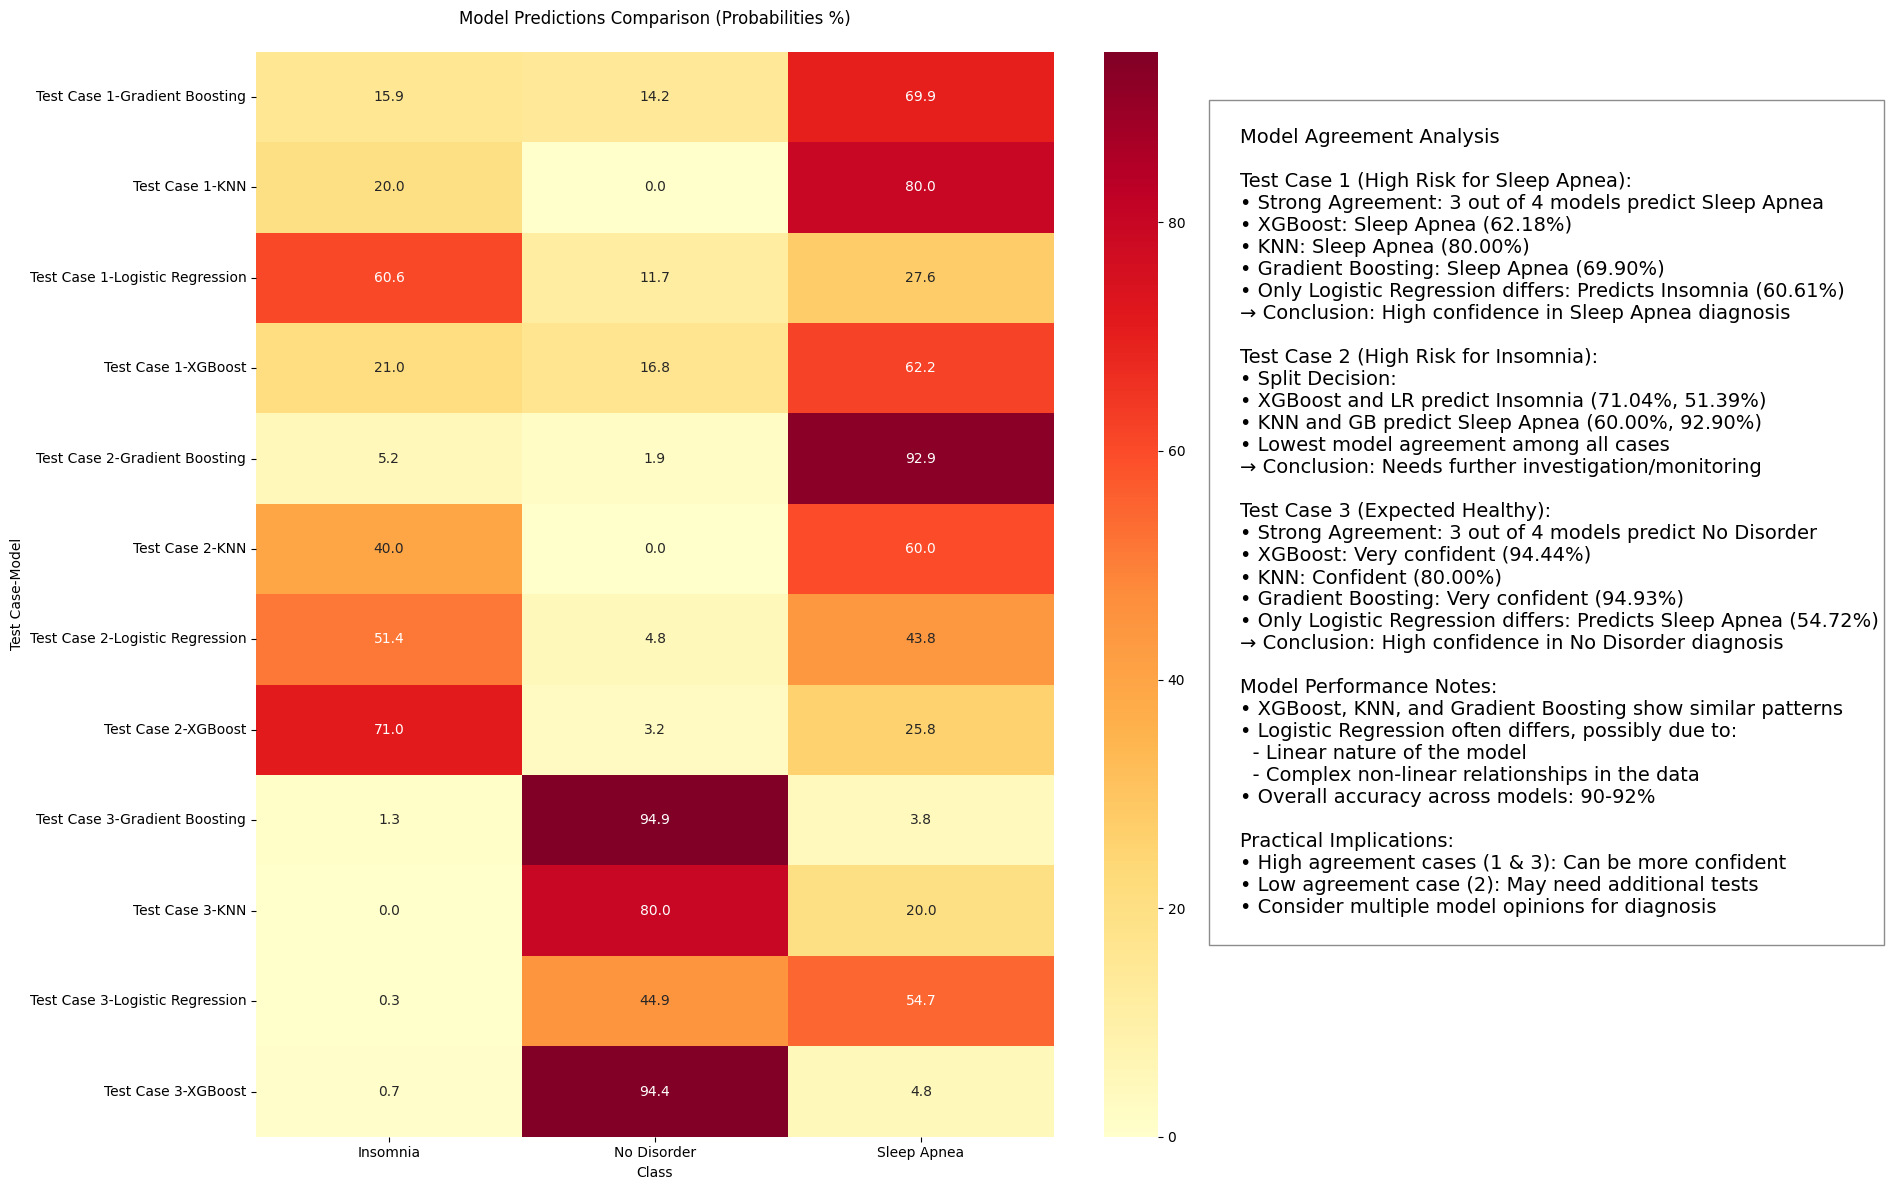

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def create_model_comparison_plot(test_cases, models, preprocessor, label_encoder):
    # Process test cases
    test_processed = preprocessor.transform(test_cases)
    
    # Create a list to store results
    results = []
    
    # Get predictions and probabilities for each model
    for model_name, model in models.items():
        probabilities = model.predict_proba(test_processed)
        
        for i, probs in enumerate(probabilities):
            for j, prob in enumerate(probs):
                results.append({
                    'Test Case': f'Test Case {i+1}',
                    'Model': model_name,
                    'Class': label_encoder.classes_[j],
                    'Probability': prob * 100  # Convert to percentage
                })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Create the main figure and grid
    fig = plt.figure(figsize=(20, 12))
    
    # Create grid for subplots
    gs = fig.add_gridspec(1, 2, width_ratios=[1.5, 1])
    
    # Create heatmap subplot
    ax_heat = fig.add_subplot(gs[0])
    
    # Create pivot table for heatmap
    pivot_table = results_df.pivot_table(
        values='Probability', 
        index=['Test Case', 'Model'],
        columns='Class'
    ).round(2)
    
    # Plot heatmap
    sns.heatmap(pivot_table, annot=True, cmap='YlOrRd', fmt='.1f', ax=ax_heat)
    ax_heat.set_title('Model Predictions Comparison (Probabilities %)', pad=20)
    
    # Create text subplot for explanations
    ax_text = fig.add_subplot(gs[1])
    ax_text.axis('off')
    
    # Detailed analysis text
    analysis_text = """
    Model Agreement Analysis
    
    Test Case 1 (High Risk for Sleep Apnea):
    • Strong Agreement: 3 out of 4 models predict Sleep Apnea
    • XGBoost: Sleep Apnea (62.18%)
    • KNN: Sleep Apnea (80.00%)
    • Gradient Boosting: Sleep Apnea (69.90%)
    • Only Logistic Regression differs: Predicts Insomnia (60.61%)
    → Conclusion: High confidence in Sleep Apnea diagnosis
    
    Test Case 2 (High Risk for Insomnia):
    • Split Decision:
    • XGBoost and LR predict Insomnia (71.04%, 51.39%)
    • KNN and GB predict Sleep Apnea (60.00%, 92.90%)
    • Lowest model agreement among all cases
    → Conclusion: Needs further investigation/monitoring
    
    Test Case 3 (Expected Healthy):
    • Strong Agreement: 3 out of 4 models predict No Disorder
    • XGBoost: Very confident (94.44%)
    • KNN: Confident (80.00%)
    • Gradient Boosting: Very confident (94.93%)
    • Only Logistic Regression differs: Predicts Sleep Apnea (54.72%)
    → Conclusion: High confidence in No Disorder diagnosis
    
    Model Performance Notes:
    • XGBoost, KNN, and Gradient Boosting show similar patterns
    • Logistic Regression often differs, possibly due to:
      - Linear nature of the model
      - Complex non-linear relationships in the data
    • Overall accuracy across models: 90-92%
    
    Practical Implications:
    • High agreement cases (1 & 3): Can be more confident
    • Low agreement case (2): May need additional tests
    • Consider multiple model opinions for diagnosis
    """
    
    # Add the analysis text
    ax_text.text(0, 0.95, analysis_text, 
                fontsize=14, 
                verticalalignment='top',
                bbox=dict(facecolor='white', 
                         edgecolor='gray',
                         alpha=0.9))
    
    plt.tight_layout()
    plt.show()
# Create and display the visualization
create_model_comparison_plot(test_cases, models, preprocessor, label_encoder)